In [1]:
import keras
from keras import layers
import keras_tuner as kt
import pickle
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def model_builder(hp):
    model = keras.Sequential()
    
    # First Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu'
    ))

    model.add(layers.Flatten())

    # Fully Connected Dense Layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))

    # Output Layer
    model.add(layers.Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [3]:
# Load already augmented data from saved pickle files
X_train_aug = pickle.load(open("../../pickles/X_train_aug.pkl", "rb"))
y_train_aug = pickle.load(open("../../pickles/y_train_aug.pkl", "rb"))
X_test = pickle.load(open("../../pickles/X_test.pkl", "rb"))
y_test = pickle.load(open("../../pickles/y_test.pkl", "rb"))

# further split the training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42)

In [4]:
# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='keras_tuner_results',
    project_name='cnn_hp_tuning'
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and Train the Best Model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate on Test Data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |conv_1_filters
5                 |5                 |conv_1_kernel
128               |128               |conv_2_filters
5                 |5                 |conv_2_kernel
64                |64                |conv_3_filters
3                 |3                 |conv_3_kernel
64                |64                |dense_units
0.001             |0.001             |learning_rate

Epoch 1/10
 13/682 ━━━━━━━━━━━━━━━━━━━━ 17:17 2s/step - accuracy: 0.1795 - loss: 1.9323

KeyboardInterrupt: 

In [8]:
display(best_hps.values)

{'conv_1_filters': 32,
 'conv_1_kernel': 5,
 'conv_2_filters': 64,
 'conv_2_kernel': 5,
 'conv_3_filters': 128,
 'conv_3_kernel': 3,
 'dense_units': 128,
 'learning_rate': 0.0001}

In [7]:
best_model.save("../../models/tuned_model.keras")

In [17]:
# Check data balance for y_train_aug
unique, counts = np.unique(np.argmax(y_train_aug, axis=1), return_counts=True)
display(dict(zip(unique, counts)))

unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
display(dict(zip(unique, counts)))

unique, counts = np.unique(np.argmax(y_val, axis=1), return_counts=True)
display(dict(zip(unique, counts)))


{0: 4200, 1: 4308, 2: 4732, 3: 4902, 4: 4518, 5: 4594}

{0: 528, 1: 591, 2: 591, 3: 586, 4: 525, 5: 586}

{0: 821, 1: 835, 2: 986, 3: 963, 4: 916, 5: 930}

In [18]:
best_model.evaluate(X_test, y_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.7872 - loss: 1.2819


[1.2220240831375122, 0.7998238801956177]

,trial_id,conv_1_filters,conv_2_filters,conv_3_filters,dense_units,kernel_size,learning_rate,val_accuracy
0,07,32,64,128,128,5,0.0001,0.813062
1,09,32,96,64,96,3,0.0001,0.812878
2,03,32,32,64,128,5,0.0001,0.807008
3,08,64,32,32,96,3,0.0001,0.804806
4,04,128,64,32,96,3,0.0001,0.803706
5,01,128,128,96,32,3,0.0010,0.801137
6,02,96,96,96,32,3,0.0010,0.796184
7,00,32,32,128,64,5,0.0100,0.180884
8,06,32,64,32,64,5,0.0100,0.180884
9,05,32,64,128,64,5,0.0100,0.176665


  trial_id  conv_1_filters  conv_2_filters  conv_3_filters  dense_units  \
0       07              32              64             128          128   
1       09              32              96              64           96   
2       03              32              32              64          128   
3       08              64              32              32           96   
4       04             128              64              32           96   
5       01             128             128              96           32   
6       02              96              96              96           32   
7       00              32              32             128           64   
8       06              32              64              32           64   
9       05              32              64             128           64   

   kernel_size  learning_rate  val_accuracy  
0            5         0.0001      0.813062  
1            3         0.0001      0.812878  
2            5         0.0001      0

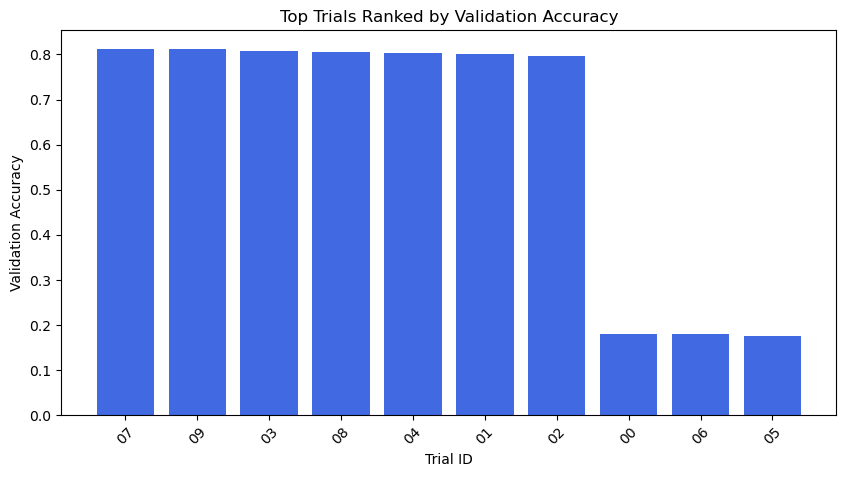

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display  # Only needed for Jupyter/Interactive Mode

# Get all trials and results
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Extract data
trial_data = []
for trial in trials:
    trial_data.append({
        'trial_id': trial.trial_id,
        'conv_1_filters': trial.hyperparameters.get('conv_1_filters'),
        'conv_2_filters': trial.hyperparameters.get('conv_2_filters'),
        'conv_3_filters': trial.hyperparameters.get('conv_3_filters'),
        'dense_units': trial.hyperparameters.get('dense_units'),
        'kernel_size': trial.hyperparameters.get('conv_1_kernel'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'val_accuracy': trial.metrics.get_best_value('val_accuracy')
    })

# Convert to DataFrame
df = pd.DataFrame(trial_data)

# Display the DataFrame
display(df)  # Works in Jupyter Notebook/VS Code Interactive Mode
print(df)    # Prints in the VS Code Terminal if running as a script

# Plot Top Trials by Accuracy
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values(by="val_accuracy", ascending=False)

plt.bar(df_sorted['trial_id'], df_sorted['val_accuracy'], color='royalblue')
plt.xlabel('Trial ID')
plt.ylabel('Validation Accuracy')
plt.title('Top Trials Ranked by Validation Accuracy')
plt.xticks(rotation=45)
plt.show()

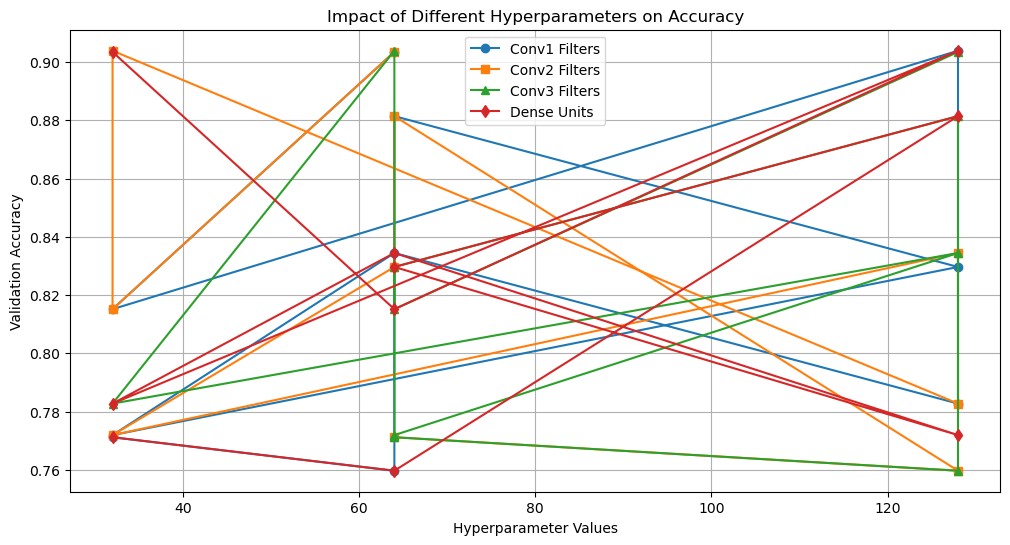

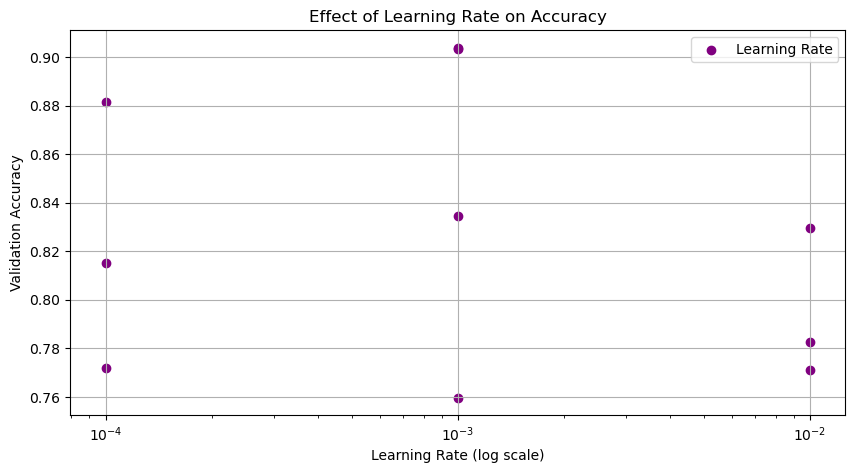

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample Data (Replace with your actual df from Keras Tuner)
trial_data = {
    'trial_id': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10'],
    'conv_1_filters': [32, 64, 64, 128, 32, 64, 128, 128, 32, 64],
    'conv_2_filters': [64, 128, 64, 64, 32, 128, 128, 32, 32, 64],
    'conv_3_filters': [64, 128, 128, 64, 64, 128, 32, 64, 64, 128],
    'dense_units': [32, 64, 128, 64, 128, 64, 32, 128, 64, 32],
    'learning_rate': [0.01, 0.001, 0.0001, 0.01, 0.0001, 0.001, 0.01, 0.001, 0.0001, 0.001],
    'val_accuracy': np.random.uniform(0.75, 0.92, 10)  # Random validation accuracy
}

df = pd.DataFrame(trial_data)

# Plot multiple analysis in one figure
plt.figure(figsize=(12, 6))

# Line plot for accuracy vs different hyperparameters
plt.plot(df['conv_1_filters'], df['val_accuracy'], marker='o', linestyle='-', label='Conv1 Filters')
plt.plot(df['conv_2_filters'], df['val_accuracy'], marker='s', linestyle='-', label='Conv2 Filters')
plt.plot(df['conv_3_filters'], df['val_accuracy'], marker='^', linestyle='-', label='Conv3 Filters')
plt.plot(df['dense_units'], df['val_accuracy'], marker='d', linestyle='-', label='Dense Units')

plt.xlabel("Hyperparameter Values")
plt.ylabel("Validation Accuracy")
plt.title("Impact of Different Hyperparameters on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for learning rate vs accuracy
plt.figure(figsize=(10, 5))
plt.scatter(df['learning_rate'], df['val_accuracy'], color='purple', label='Learning Rate')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Validation Accuracy")
plt.xscale('log')  # Log scale for better visibility
plt.title("Effect of Learning Rate on Accuracy")
plt.legend()
plt.grid(True)
plt.show()